# Preprocessing of data 

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('./train_with_rmssd_pnn30_sdnn_si_sd.tsv',index_col=0)

In [ ]:
data_clipped = pd.read_csv('./train_with_rmssd_pnn30_sdnn_si_sd_clipped.tsv',index_col=0)

In [ ]:
data_cat = pd.read_csv('./train_with_rmssd_pnn30_sdnn_si_sd_craft.tsv',index_col=0)

In [ ]:
data_cat = data_cat.replace([np.inf, -np.inf], np.nan)

In [ ]:
data_cat = data_cat.fillna(0)

In [ ]:
data_clipped.head()

,id,time,x,y,RMSSD_3,RMSSD_5,RMSSD_7,pNN50_10,pNN50_20,pNN50_30,pNN30_10,pNN30_20,pNN30_30,SDNN_3,SDNN_5,SDNN_7,SDNN_10,SDNN_20,SI_10,SI_5,SI_20,SI_30,SI_40,SDSD_5,SDSD_10,SDSD_20,SD1_5,SD1_10,SD1_20
0,1,0,800,0,786.022900,799.137035,824.532191,10,10,13.333333,20,40,46.666667,8.219219,13.242356,41.952354,68.8,69.148825,0.035613,0.160256,0.053501,0.024262,0.024262,19.874607,34.672364,39.637135,14.053469,24.517064,28.027687
1,1,780,780,0,786.022900,799.137035,824.532191,10,10,13.333333,20,40,46.666667,8.219219,13.242356,41.952354,68.8,69.148825,0.035613,0.160256,0.053501,0.024262,0.024262,19.874607,34.672364,39.637135,14.053469,24.517064,28.027687
2,1,1572,792,0,786.022900,799.137035,824.532191,10,10,13.333333,20,40,46.666667,8.219219,13.242356,41.952354,68.8,69.148825,0.035613,0.160256,0.053501,0.024262,0.024262,19.874607,34.672364,39.637135,14.053469,24.517064,28.027687
3,1,2392,820,0,806.121579,799.137035,824.532191,10,10,13.333333,20,40,46.666667,16.759740,13.242356,41.952354,68.8,69.148825,0.035613,0.160256,0.053501,0.024262,0.024262,19.874607,34.672364,39.637135,14.053469,24.517064,28.027687
4,1,3196,804,0,812.039408,799.137035,824.532191,10,10,13.333333,20,40,46.666667,11.469767,13.242356,41.952354,68.8,69.148825,0.035613,0.160256,0.053501,0.024262,0.024262,19.874607,34.672364,39.637135,14.053469,24.517064,28.027687


In [ ]:
data.columns

Index(['id', 'time', 'x', 'y', 'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10', 'SD1_20', 'SI_30',
       'SI_40'],
      dtype='object')

In [ ]:
num_cols = [
    'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', #'SI_5', 
       'SI_20',
       'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10', 'SD1_20', 'SI_30',
       'SI_40'
]

In [ ]:
feature_cols = num_cols #+ cat_cols
target_col = 'y'

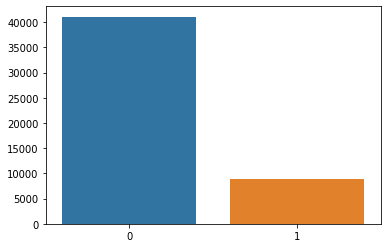

In [ ]:
ax = sns.barplot(data['y'].value_counts().index, list(data['y'].value_counts()))


In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
scaler = StandardScaler()
train_scaled_num = scaler.fit_transform(data[num_cols])

In [ ]:
X = pd.DataFrame(train_scaled_num, columns=num_cols)
X.head()

,RMSSD_3,RMSSD_5,RMSSD_7,pNN50_10,pNN50_20,pNN50_30,pNN30_10,pNN30_20,pNN30_30,SDNN_3,SDNN_5,SDNN_7,SDNN_10,SDNN_20,SI_10,SI_20,SDSD_5,SDSD_10,SDSD_20,SD1_5,SD1_10,SD1_20,SI_30,SI_40
0,1.042061,1.199244,0.05418,-0.539975,-0.660967,-0.547296,-0.40449,0.301887,0.435909,-0.444942,-0.434607,0.1583,0.704838,0.605339,-0.478399,-0.452711,-0.430088,-0.335147,-0.363031,-0.430088,-0.335147,-0.363031,-0.521058,-0.579875
1,1.042061,1.199244,0.05418,-0.539975,-0.660967,-0.547296,-0.40449,0.301887,0.435909,-0.444942,-0.434607,0.1583,0.704838,0.605339,-0.478399,-0.452711,-0.430088,-0.335147,-0.363031,-0.430088,-0.335147,-0.363031,-0.521058,-0.579875
2,1.042061,1.199244,0.05418,-0.539975,-0.660967,-0.547296,-0.40449,0.301887,0.435909,-0.444942,-0.434607,0.1583,0.704838,0.605339,-0.478399,-0.452711,-0.430088,-0.335147,-0.363031,-0.430088,-0.335147,-0.363031,-0.521058,-0.579875
3,1.223023,1.199244,0.05418,-0.539975,-0.660967,-0.547296,-0.40449,0.301887,0.435909,-0.236217,-0.434607,0.1583,0.704838,0.605339,-0.478399,-0.452711,-0.430088,-0.335147,-0.363031,-0.430088,-0.335147,-0.363031,-0.521058,-0.579875
4,1.276305,1.199244,0.05418,-0.539975,-0.660967,-0.547296,-0.40449,0.301887,0.435909,-0.365500,-0.434607,0.1583,0.704838,0.605339,-0.478399,-0.452711,-0.430088,-0.335147,-0.363031,-0.430088,-0.335147,-0.363031,-0.521058,-0.579875


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X.values, data['y'].values, 
                                                    train_size=0.8,
                                                    random_state=42)

# Catboost without scaling

In [ ]:
!pip install catboost

In [ ]:
# YOUR CODE
import catboost

In [ ]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(data[num_cols], 
                                                       data['y'].values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                            #  cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat, y_train_cat)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat)
y_test_predicted = boosting_model.predict(X_valid_cat)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat, y_train_predicted,multi_class='ovo'))

Best score - 0.7676765306262922


In [ ]:
print('Best score -', roc_auc_score(y_valid_cat, y_test_predicted,multi_class='ovo'))

Best score - 0.7148453956639457


In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=200,
                                             silent=True,
                                            #  cat_features=cat_cols,
                                        loss_function='MultiClass',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.7, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7],
                            'border_count':[5, 10, 20, 32, 50]}, 
                           X_train_cat,
                          y_train_cat, plot=True, refit=True,);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8384187746
bestIteration = 199

0:	loss: 0.8384188	best: 0.8384188 (0)	total: 3.65s	remaining: 32.8s

bestTest = 0.8536567727
bestIteration = 191

1:	loss: 0.8536568	best: 0.8536568 (1)	total: 8.55s	remaining: 34.2s

bestTest = 0.8401375526
bestIteration = 195

2:	loss: 0.8401376	best: 0.8536568 (1)	total: 11.7s	remaining: 27.3s

bestTest = 0.8447831385
bestIteration = 199

3:	loss: 0.8447831	best: 0.8536568 (1)	total: 16.4s	remaining: 24.6s

bestTest = 0.8369035211
bestIteration = 196

4:	loss: 0.8369035	best: 0.8536568 (1)	total: 19.2s	remaining: 19.2s

bestTest = 0.8618567768
bestIteration = 186

5:	loss: 0.8618568	best: 0.8618568 (5)	total: 23.9s	remaining: 16s

bestTest = 0.8569177914
bestIteration = 193

6:	loss: 0.8569178	best: 0.8618568 (5)	total: 27.8s	remaining: 11.9s

bestTest = 0.8349668756
bestIteration = 198

7:	loss: 0.8349669	best: 0.8618568 (5)	total: 31.6s	remaining: 7.9s

bestTest = 0.8552420751
bestIteration = 197

8:	loss: 0.8552421	best: 0.8618568 (5

In [ ]:
grid_search_result['params']

{'border_count': 50,
 'depth': 7,
 'l2_leaf_reg': 7.979797979797979,
 'learning_rate': 0.5526315789473684}

In [ ]:
!pip install shap
import shap

In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=200, 
                                            #  cat_features=cat_cols,
                                             learning_rate=0.5526315789473684,
                                             l2_leaf_reg=7.979797979797979,
                                             depth=7,
                                             border_count=50,
                                             silent=True)

boosting_model.fit(X_train_cat, y_train_cat)

In [ ]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer.shap_values(X_valid_cat)

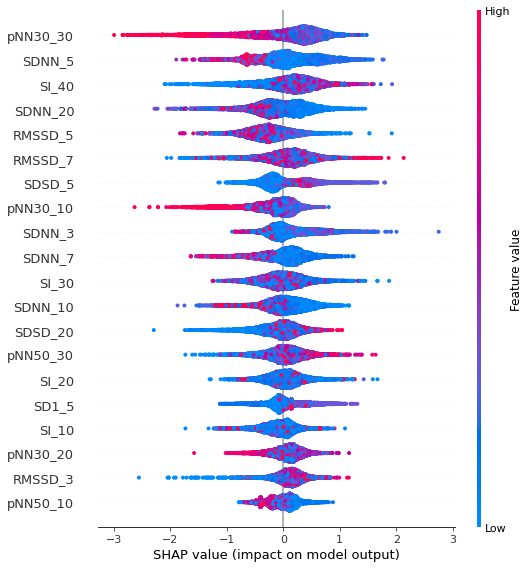

In [ ]:
shap.summary_plot(shap_values, X_valid_cat, #plot_type="bar"
)

In [ ]:
X100 = shap.utils.sample(X_valid_cat, 100)
explainer = shap.Explainer(boosting_model.predict, X100)
shap_values = explainer(X_valid_cat)

Permutation explainer: 10013it [12:17, 13.58it/s]


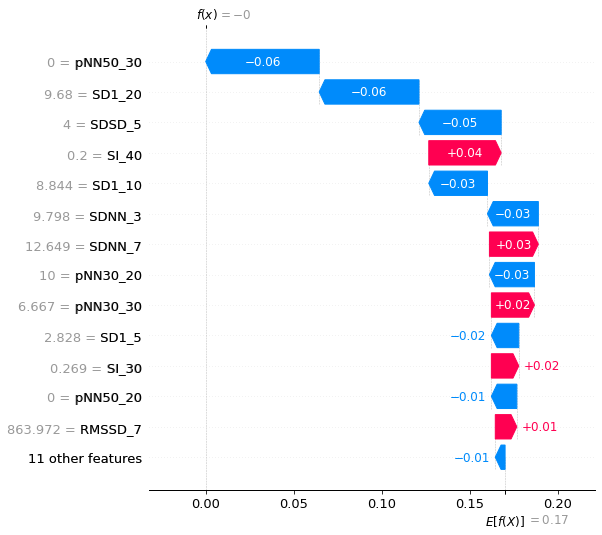

In [ ]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [ ]:
explainer_2 = shap.TreeExplainer(boosting_model)
shap_values_2 = explainer_2.shap_values(X_valid_cat)
X_valid_cat.columns[np.argsort(np.abs(shap_values_2).mean(0))]

Index(['SD1_5', 'pNN50_10', 'SD1_10', 'SD1_20', 'pNN50_20', 'RMSSD_3',
       'pNN30_20', 'SDSD_10', 'SDNN_10', 'SI_20', 'SDNN_3', 'pNN30_10',
       'pNN50_30', 'RMSSD_5', 'SDNN_7', 'SI_10', 'SI_30', 'RMSSD_7', 'SDNN_20',
       'SI_40', 'SDSD_20', 'SDSD_5', 'pNN30_30', 'SDNN_5'],
      dtype='object')

In [ ]:
vals= np.abs(shap_values_2).mean(0)

feature_importance = pd.DataFrame(list(zip(X_valid_cat.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
10,SDNN_5,0.661814
8,pNN30_30,0.625423
16,SDSD_5,0.581299
18,SDSD_20,0.552896
23,SI_40,0.526594


In [ ]:
best_features = feature_importance[0:10].col_name.values

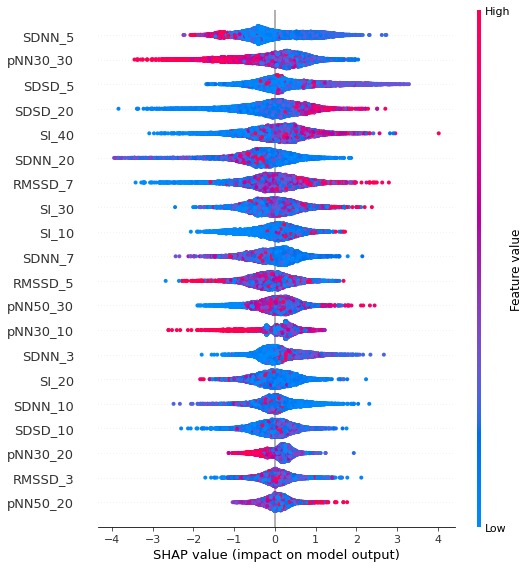

In [ ]:
shap.summary_plot(shap_values_2, X_valid_cat, #plot_type="bar"
)

In [ ]:
import tensorflow as tf

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat)
y_test_predicted = boosting_model.predict(X_valid_cat)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat, y_test_predicted)
m.result().numpy()

0.89482623

# Catboost with features

In [ ]:
X_train_cat_2, X_valid_cat_2, y_train_cat_2, y_valid_cat_2 = train_test_split(data[best_features], 
                                                       data['y'].values, 
                                                       train_size=0.8, 
                                                       random_state=42,
                                                       stratify=data['id'].values)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                            #  cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.744047560343099


In [ ]:
print('Best score -', roc_auc_score(y_valid_cat_2, y_test_predicted,multi_class='ovo'))

Best score - 0.7069449804613204


In [ ]:
boosting_model = catboost.CatBoostClassifier(#iterations=300,
                                             silent=True,
                                            #  cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7,8],
                            'iterations': [200,500,700],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat_2,
                          y_train_cat_2, plot=True, refit=True,);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8296983378
bestIteration = 159

0:	loss: 0.8296983	best: 0.8296983 (0)	total: 2.44s	remaining: 22s

bestTest = 0.8417067506
bestIteration = 673

1:	loss: 0.8417068	best: 0.8417068 (1)	total: 10.7s	remaining: 42.9s

bestTest = 0.8537749171
bestIteration = 694

2:	loss: 0.8537749	best: 0.8537749 (2)	total: 20s	remaining: 46.6s

bestTest = 0.8613825823
bestIteration = 698

3:	loss: 0.8613826	best: 0.8613826 (3)	total: 30.2s	remaining: 45.3s

bestTest = 0.8876919164
bestIteration = 696

4:	loss: 0.8876919	best: 0.8876919 (4)	total: 55.1s	remaining: 55.1s

bestTest = 0.8473775597
bestIteration = 695

5:	loss: 0.8473776	best: 0.8876919 (4)	total: 1m 8s	remaining: 45.9s

bestTest = 0.8597912116
bestIteration = 674

6:	loss: 0.8597912	best: 0.8876919 (4)	total: 1m 22s	remaining: 35.4s

bestTest = 0.8886356265
bestIteration = 499

7:	loss: 0.8886356	best: 0.8886356 (7)	total: 1m 42s	remaining: 25.7s

bestTest = 0.8215185671
bestIteration = 198

8:	loss: 0.8215186	best: 0.8886356 (

In [ ]:
grid_search_result['params']

{'depth': 6,
 'grow_policy': 'Depthwise',
 'iterations': 500,
 'l2_leaf_reg': 9.191919191919192,
 'learning_rate': 0.5684210526315789}

In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=500, 
                                            #  cat_features=cat_cols,
                                             learning_rate=0.5684210526315789,
                                             l2_leaf_reg=9.191919191919192,
                                             grow_policy='Depthwise',
                                             depth=6,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.9120056

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.7211142766698323

# Catboost without features on clipped

In [ ]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(data_clipped[num_cols], 
                                                       data_clipped['y'].values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                            #  cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat, y_train_cat)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat)
y_test_predicted = boosting_model.predict(X_valid_cat)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat, y_train_predicted,multi_class='ovo'))

Best score - 0.7800021090503197


In [ ]:
print('Best score -', roc_auc_score(y_valid_cat, y_test_predicted,multi_class='ovo'))

Best score - 0.7321747048915204


In [ ]:
boosting_model = catboost.CatBoostClassifier(#iterations=200,
                                             silent=True,
                                            #  cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7,8],
                            'iterations': [200,500,700],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat,
                          y_train_cat, plot=True, refit=True,);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8776891244
bestIteration = 197

0:	loss: 0.8776891	best: 0.8776891 (0)	total: 2.95s	remaining: 26.6s

bestTest = 0.8941423752
bestIteration = 697

1:	loss: 0.8941424	best: 0.8941424 (1)	total: 13s	remaining: 51.8s

bestTest = 0.9000696275
bestIteration = 671

2:	loss: 0.9000696	best: 0.9000696 (2)	total: 24.4s	remaining: 57s

bestTest = 0.9080222704
bestIteration = 684

3:	loss: 0.9080223	best: 0.9080223 (3)	total: 37.6s	remaining: 56.4s

bestTest = 0.9252808988
bestIteration = 649

4:	loss: 0.9252809	best: 0.9252809 (4)	total: 1m 6s	remaining: 1m 6s

bestTest = 0.8945917789
bestIteration = 696

5:	loss: 0.8945918	best: 0.9252809 (4)	total: 1m 21s	remaining: 54.6s

bestTest = 0.9088449376
bestIteration = 696

6:	loss: 0.9088449	best: 0.9252809 (4)	total: 1m 37s	remaining: 41.7s

bestTest = 0.9240738458
bestIteration = 499

7:	loss: 0.9240738	best: 0.9252809 (4)	total: 2m 1s	remaining: 30.3s

bestTest = 0.8731580054
bestIteration = 196

8:	loss: 0.8731580	best: 0.9252809 (

In [ ]:
grid_search_result['params']

{'depth': 8,
 'grow_policy': 'SymmetricTree',
 'iterations': 700,
 'l2_leaf_reg': 9.595959595959595,
 'learning_rate': 0.8052631578947369}

In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=700, 
                                            #  cat_features=cat_cols,
                                             learning_rate=0.8052631578947369,
                                             l2_leaf_reg=9.595959595959595,
                                             depth=8,
                                             grow_policy='SymmetricTree',
                                            #  border_count=50,
                                             silent=True)

boosting_model.fit(X_train_cat, y_train_cat)

In [ ]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer.shap_values(X_valid_cat)

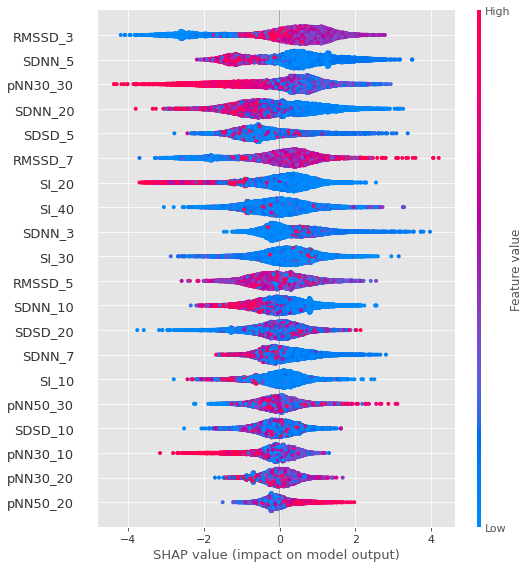

In [ ]:
shap.summary_plot(shap_values, X_valid_cat, #plot_type="bar"
)

In [ ]:
X100 = shap.utils.sample(X_valid_cat, 100)
explainer = shap.Explainer(boosting_model.predict, X100)
shap_values = explainer(X_valid_cat)

Permutation explainer: 10013it [12:17, 13.58it/s]


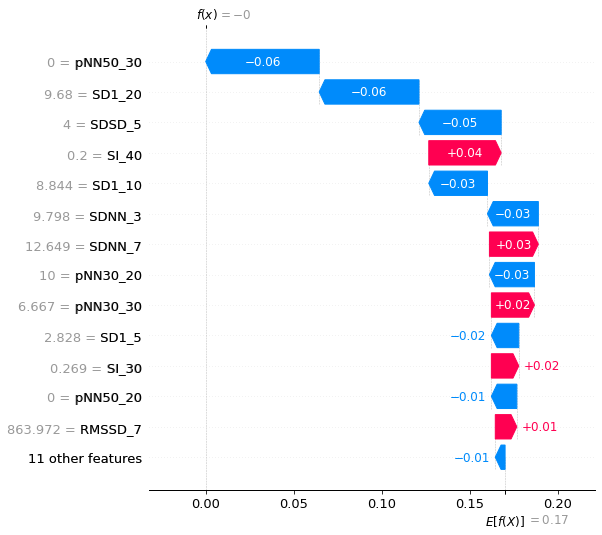

In [ ]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [ ]:
explainer_2 = shap.TreeExplainer(boosting_model)
shap_values_2 = explainer_2.shap_values(X_valid_cat)

Index(['pNN50_10', 'SD1_10', 'SD1_20', 'SD1_5', 'pNN50_20', 'pNN30_20',
       'pNN30_10', 'SDSD_10', 'pNN50_30', 'SI_10', 'SDNN_7', 'SDSD_20',
       'SDNN_10', 'RMSSD_5', 'SI_30', 'SDNN_3', 'SI_40', 'SI_20', 'RMSSD_7',
       'SDSD_5', 'SDNN_20', 'pNN30_30', 'SDNN_5', 'RMSSD_3'],
      dtype='object')

In [ ]:
vals= np.abs(shap_values_2).mean(0)

feature_importance = pd.DataFrame(list(zip(X_valid_cat.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
0,RMSSD_3,0.991328
10,SDNN_5,0.881758
8,pNN30_30,0.866527
13,SDNN_20,0.781161
16,SDSD_5,0.703057


In [ ]:
best_features = feature_importance[0:10].col_name.values

In [ ]:
sns.set_style('ticks')

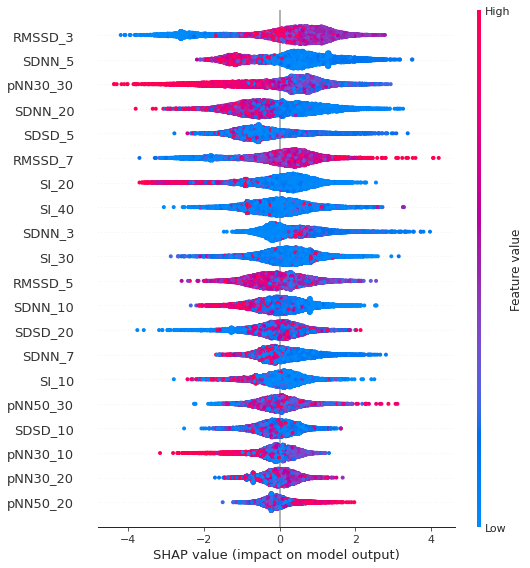

In [ ]:
shap.summary_plot(shap_values_2, X_valid_cat, #plot_type="bar"
)

In [ ]:
import tensorflow as tf

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat)
y_test_predicted = boosting_model.predict(X_valid_cat)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat, y_test_predicted)
m.result().numpy()

0.92833525

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat, y_test_predicted, average='binary')

0.7440212577502214

# Catboost with features on clipped

In [ ]:
X_train_cat_2, X_valid_cat_2, y_train_cat_2, y_valid_cat_2 = train_test_split(data_clipped[best_features], 
                                                       data_clipped['y'].values, 
                                                       train_size=0.8, 
                                                       random_state=42,
                                                       stratify=data_clipped['id'].values)

In [ ]:
X_train_cat_2 = data_clipped[data_clipped.id < 200][num_cols]
X_valid_cat_2 = data_clipped[data_clipped.id >= 200][num_cols]
y_train_cat_2 = data_clipped[data_clipped.id < 200]['y'].values
y_valid_cat_2 = data_clipped[data_clipped.id >= 200]['y'].values

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                            #  cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.7526985928876149


In [ ]:
print('Best score -', roc_auc_score(y_valid_cat_2, y_test_predicted,multi_class='ovo'))

Best score - 0.704385171535668


In [ ]:
boosting_model = catboost.CatBoostClassifier(#iterations=300,
                                             silent=True,
                                            #  cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7,8],
                            'iterations': [200,500,700],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat_2,
                    y_train_cat_2, plot=True, refit=True,   );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8627930697
bestIteration = 192

0:	loss: 0.8627931	best: 0.8627931 (0)	total: 2.55s	remaining: 23s

bestTest = 0.877269984
bestIteration = 663

1:	loss: 0.8772700	best: 0.8772700 (1)	total: 11.5s	remaining: 46s

bestTest = 0.8868898812
bestIteration = 609

2:	loss: 0.8868899	best: 0.8868899 (2)	total: 21.7s	remaining: 50.6s

bestTest = 0.8995195054
bestIteration = 671

3:	loss: 0.8995195	best: 0.8995195 (3)	total: 33.3s	remaining: 49.9s

bestTest = 0.9107284235
bestIteration = 684

4:	loss: 0.9107284	best: 0.9107284 (4)	total: 54.7s	remaining: 54.7s

bestTest = 0.8792353731
bestIteration = 693

5:	loss: 0.8792354	best: 0.9107284 (4)	total: 1m 7s	remaining: 45.1s

bestTest = 0.8974375672
bestIteration = 685

6:	loss: 0.8974376	best: 0.9107284 (4)	total: 1m 21s	remaining: 34.7s

bestTest = 0.9153371552
bestIteration = 451

7:	loss: 0.9153372	best: 0.9153372 (7)	total: 1m 38s	remaining: 24.7s

bestTest = 0.8559287189
bestIteration = 199

8:	loss: 0.8559287	best: 0.9153372 (7

In [ ]:
grid_search_result['params']

{'depth': 6,
 'grow_policy': 'Depthwise',
 'iterations': 500,
 'l2_leaf_reg': 9.191919191919192,
 'learning_rate': 0.5684210526315789}

In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=500, 
                                            #  cat_features=cat_cols,
                                             learning_rate=0.5684210526315789,
                                             l2_leaf_reg=9.191919191919192,
                                             grow_policy='Depthwise',
                                             depth=6,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.92238384

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.7102746066029004

# Catboost with categorial values on clipped

In [ ]:
# X_train_cat_2, X_valid_cat_2, y_train_cat_2, y_valid_cat_2 = train_test_split(data_clipped[best_features], 
#                                                        data_clipped['y'].values, 
#                                                        train_size=0.8, 
#                                                        random_state=42,
#                                                        stratify=data_clipped['id'].values)

In [ ]:
data_cat.columns

Index(['id', 'time', 'x', 'y', 'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands'],
      dtype='object')

In [ ]:
X_train_cat_2 = data_cat[data_cat.id < 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
X_valid_cat_2 = data_cat[data_cat.id >= 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
y_train_cat_2 = data_cat[data_cat.id < 200]['y'].values
y_valid_cat_2 = data_cat[data_cat.id >= 200]['y'].values

In [ ]:
cat_cols = ['by_hands']

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.8010868684223652


In [ ]:
print('Best score -', roc_auc_score(y_valid_cat_2, y_test_predicted,multi_class='ovo'))

Best score - 0.6292345342431142


In [ ]:
boosting_model = catboost.CatBoostClassifier(#iterations=300,
                                             silent=True,
                                             cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7,8],
                            'iterations': [200,500,700,900],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat_2,
                    y_train_cat_2, plot=True, refit=True,   );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8924223257
bestIteration = 691

0:	loss: 0.8924223	best: 0.8924223 (0)	total: 9.48s	remaining: 1m 25s

bestTest = 0.8848558892
bestIteration = 495

1:	loss: 0.8848559	best: 0.8924223 (0)	total: 17.1s	remaining: 1m 8s

bestTest = 0.9002831288
bestIteration = 451

2:	loss: 0.9002831	best: 0.9002831 (2)	total: 24.8s	remaining: 58s

bestTest = 0.9295592988
bestIteration = 619

3:	loss: 0.9295593	best: 0.9295593 (3)	total: 59.6s	remaining: 1m 29s

bestTest = 0.9277208602
bestIteration = 537

4:	loss: 0.9277209	best: 0.9295593 (3)	total: 1m 22s	remaining: 1m 22s

bestTest = 0.9349019302
bestIteration = 677

5:	loss: 0.9349019	best: 0.9349019 (5)	total: 2m 42s	remaining: 1m 48s

bestTest = 0.8928911944
bestIteration = 854

6:	loss: 0.8928912	best: 0.9349019 (5)	total: 3m 4s	remaining: 1m 18s

bestTest = 0.9129674224
bestIteration = 196

7:	loss: 0.9129674	best: 0.9349019 (5)	total: 3m 12s	remaining: 48.1s

bestTest = 0.9318776422
bestIteration = 730

8:	loss: 0.9318776	best: 0.9

In [ ]:
grid_search_result['params']

{'depth': 8,
 'grow_policy': 'Depthwise',
 'iterations': 900,
 'l2_leaf_reg': 9.191919191919192,
 'learning_rate': 0.5684210526315789}

In [ ]:
boosting_model = catboost.CatBoostClassifier(iterations=900, 
                                             cat_features=cat_cols,
                                             learning_rate=0.5684210526315789,
                                             l2_leaf_reg=9.191919191919192,
                                             grow_policy='Depthwise',
                                             depth=8,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.8010868684223652


In [ ]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [ ]:
import tensorflow as tf
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.85939085

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.38146167557932265

In [ ]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer.shap_values(X_valid_cat_2)

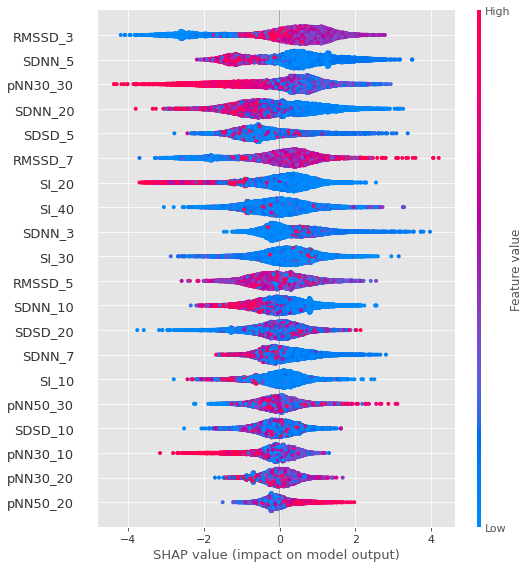

In [ ]:
shap.summary_plot(shap_values, X_valid_cat_2, #plot_type="bar"
)

In [ ]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_valid_cat_2.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

In [ ]:
y_test_predicted = boosting_model.predict_proba(X_valid_cat_2)[:, 1]

In [ ]:
f1_score(y_valid, list(map(lambda x: 0 if x < 0.5 else 1, (y_test_predicted +[i[0] for i in nn_predictions]) /2)), average='binary')

0.3588785046728972

# Ensemble

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(AdaBoostClassifier(n_estimators=10, random_state=42))
models.append(DecisionTreeClassifier(max_depth=8))
models.append(catboost.CatBoostClassifier(iterations=500, 
                                            #  cat_features=cat_cols,
                                             learning_rate=0.5684210526315789,
                                             l2_leaf_reg=9.191919191919192,
                                             grow_policy='Depthwise',
                                             depth=6,
                                             silent=True))

In [ ]:
data_clipped = data_clipped.replace([np.inf, -np.inf], np.nan)

In [ ]:
data_clipped = data_clipped.fillna(0)

In [ ]:
X_train_cat_2 = data_clipped[data_clipped.id < 200][num_cols]
X_valid_cat_2 = data_clipped[data_clipped.id >= 200][num_cols]
y_train_cat_2 = data_clipped[data_clipped.id < 200]['y'].values
y_valid_cat_2 = data_clipped[data_clipped.id >= 200]['y'].values

In [ ]:
scaler = StandardScaler()
X_train_cat_2 = scaler.fit_transform(X_train_cat_2)
X_valid_cat_2 = scaler.fit_transform(X_valid_cat_2)

In [ ]:
meta_features_train = np.zeros((X_train_cat_2.shape[0], 0))
meta_features_test = np.zeros((X_valid_cat_2.shape[0], 0))

In [ ]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train_cat_2, X_valid_cat_2, y_train_cat_2, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

In [ ]:
stacking_model = RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1)
stacking_model.fit(meta_features_train, y_train_cat_2)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

In [ ]:
y_train_predicted = stacking_model.predict(meta_features_train)
y_test_predicted = stacking_model.predict(meta_features_test)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.83338964

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.004037141703673799

In [ ]:
rand_seed = 42

In [ ]:
from sklearn.model_selection import KFold

def stackingModel(base_models, meta_model, features, target, nfolds=10):
    #Split data into folds
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=rand_seed)
    #initialize arrays to hold predictions
    test_predictions = np.zeros((features.shape[0], len(base_models)))
    train_predictions = np.zeros((features.shape[0], len(base_models)))
    
    # Train base models
    for i, model in enumerate(base_models):
        for train_index, test_index in kfold.split(features, target):
            #Fit train data on the model
            model.fit(np.array(features)[train_index], np.array(target)[train_index])
            
            #Make prediction on the holdout data
            y_pred = model.predict(np.array(features)[test_index])
            #make predictions on train data
            t_pred = model.predict(np.array(features)[train_index])
            
            #Append the prediction to out of folds
            test_predictions[test_index, i] = y_pred
            #Append predictions to train predictions
            train_predictions[train_index, i] = t_pred


    # Now train the meta-model using the train predictions as new feature
    meta_model.fit(train_predictions, target)
    #Make fianl predictions on the average of out of fold predictions
    final_preds = meta_model.predict(np.mean([test_predictions], axis=0))
    
    return meta_model, final_preds

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
log_cf = LogisticRegression(solver='lbfgs', random_state=42)
svc_cf = SVC(gamma='scale', random_state=42)
# knn_cf = KNeighborsClassifier()

In [ ]:
#bagging algorithms for classification
rand_forest_cf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_tree_cf = ExtraTreesClassifier(n_estimators=100, random_state=42)
#We use svc as our base model for bagging
bagging_meta_cf = BaggingClassifier(svc_cf, n_estimators=10, random_state=42)

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

In [ ]:
kfold = model_selection.KFold(n_splits=10, random_state=42)
# create the sub models
estimators = []
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
estimators.append(('rand', model1))
model2 = BaggingClassifier(svc_cf, n_estimators=10, random_state=42)
estimators.append(('bag', model2))
model3 = AdaBoostClassifier(n_estimators=10, random_state=42)
estimators.append(('ada', model3))
model4 = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
estimators.append(('xgb', model4))
model5 = LGBMClassifier(
          objective='binary',
          boosting='gbdt',
          learning_rate = 0.05,
          max_depth = 8,
          num_leaves = 80,
          n_estimators = 400,
          bagging_fraction = 0.8,
          feature_fraction = 0.9)
estimators.append(('lgbm', model5))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble,  X_train_cat_2, y_train_cat_2, cv=kfold)
print(results.mean())

0.8859457092819614


In [ ]:
ensemble.fit(X_train_cat_2, y_train_cat_2)

VotingClassifier(estimators=[('rand',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
      

In [ ]:
y_train_predicted = ensemble.predict(X_train_cat_2)
y_test_predicted = ensemble.predict(X_valid_cat_2)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.8339974

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.008870967741935486


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_cat_2, y_train_cat_2)

In [ ]:
rf_random.best_params_

# PyTorch NN

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm_notebook as tqdm

In [ ]:
from sklearn import metrics

In [ ]:
def split_dataset(trainset, valid_size=0.2, batch_size=64):
    num_train = len(trainset)
    
    indices = list(range(num_train))
    np.random.shuffle(indices)
    
    split = int(np.floor(valid_size * num_train))
    
    valid_idx, train_idx = indices[:split], indices[split:]
    
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_sampler = SubsetRandomSampler(train_idx)
    
    valid_loader = DataLoader(trainset, 
                              batch_size=batch_size, 
                              sampler=valid_sampler)
    train_loader = DataLoader(trainset, 
                              batch_size=batch_size, 
                              sampler=train_sampler)
    
    return train_loader, valid_loader

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, data, targets=None,
                 is_train=True, cat_cols_idx=None,
                 cont_cols_idx=None):
        self.data = data
        self.targets = targets
        self.is_train = is_train
        self.cat_cols_idx = cat_cols_idx
        self.cont_cols_idx = cont_cols_idx
    
    def __getitem__(self, idx):
        row = self.data[idx].astype('float32')
        
        data_cat = []
        data_cont = []
        
        result = None
        
        if self.cat_cols_idx:
            data_cat = torch.tensor(row[self.cat_cols_idx])
            
        if self.cont_cols_idx:
            data_cont = torch.tensor(row[self.cont_cols_idx])
                
        data = [data_cat, data_cont]
                
        if self.is_train:
            result = {'data': data,
                      'target': torch.tensor(self.targets[idx])}
        else:
            result = {'data': data}
            
        return result
            
    
    def __len__(self):
        return(len(self.data))

In [ ]:
data_cat.columns

Index(['id', 'time', 'x', 'y', 'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands'],
      dtype='object')

In [ ]:
categorical = ['by_hands']
continuous = ['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20']

cat_cols_idx, cont_cols_idx = list(), list()

for idx, column in enumerate(pd.concat([data_cat[continuous],data_cat[categorical]],axis=1).columns):
    if column in categorical:
        cat_cols_idx.append(idx)
    elif column in continuous:
        cont_cols_idx.append(idx)

In [ ]:
X_train_cat_2 = X_train_cat_2.replace([np.inf, -np.inf], np.nan)

In [ ]:
X_train_cat_2 = X_train_cat_2.fillna(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(X_train_cat_2[list(set(continuous))])

In [ ]:
train_data = np.concatenate((train_data,np.expand_dims(X_train_cat_2['by_hands'].values,axis=0).T), axis=1)

In [ ]:
# train_data = 
train_target = y_train_cat_2

# test_data = test.drop('target', axis=1).to_numpy()

In [ ]:
train_dataset = ClassificationDataset(train_data, 
                                      targets=train_target,
                                      cat_cols_idx=cat_cols_idx,
                                      cont_cols_idx=cont_cols_idx)

In [ ]:
train_loader, valid_loader = split_dataset(train_dataset, 
                                           valid_size=0.2, 
                                           batch_size=2000)

In [ ]:
class ClassificationEmbdNN(torch.nn.Module):
    
    def __init__(self, emb_dims, no_of_cont=None):
        super(ClassificationEmbdNN, self).__init__()
        
        self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y)
                                               for x, y in emb_dims])
        
        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.emb_dropout = torch.nn.Dropout(0.2)
        
        self.no_of_cont = 0
        if no_of_cont:
            self.no_of_cont = no_of_cont
            self.bn_cont = torch.nn.BatchNorm1d(no_of_cont)
        
        self.fc1 = torch.nn.Linear(in_features=self.no_of_embs + self.no_of_cont, 
                                   out_features=256)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.act1 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(in_features=256, 
                                   out_features=256)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.act2 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(in_features=256, 
                                   out_features=64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.act3 = torch.nn.ReLU()
        
        self.fc4 = torch.nn.Linear(in_features=64, 
                                   out_features=1)
        self.act4 = torch.nn.Sigmoid()
        
    def forward(self, x_cat, x_cont=None):
        if self.no_of_embs != 0:
            x = [emb_layer(x_cat[:, i])
                 for i, emb_layer in enumerate(self.emb_layers)]
        
            x = torch.cat(x, 1)
            x = self.emb_dropout(x)
            
        if self.no_of_cont != 0:
            x_cont = self.bn_cont(x_cont)
            
            if self.no_of_embs != 0:
                x = torch.cat([x, x_cont], 1)
            else:
                x = x_cont
        
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        x = self.act4(x)
        
        return x

In [ ]:
def train_network(model, train_loader, valid_loader,
                  loss_func, optimizer, n_epochs=20,
                  saved_model='model.pt'):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses = list()
    valid_losses = list()
    
    valid_loss_min = np.Inf
    
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        train_auc = 0.0
        valid_auc = 0.0
        
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long),
                           batch['data'][1].to(device, 
                                               dtype=torch.float))
            
            loss = loss_func(output, batch['target'].float().unsqueeze(1).to(device, 
                                                        dtype=torch.float))
            
            loss.backward()
            optimizer.step()
            
            train_auc += metrics.roc_auc_score(batch['target'].cpu().numpy(),
                                               output.detach().cpu().numpy())

            train_loss += loss.item() * batch['data'][0].size(0)  #!!!
    

        model.eval()
        for batch in tqdm(valid_loader):
            
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long),
                           batch['data'][1].to(device, 
                                               dtype=torch.float))
            
            
            loss = loss_func(output, batch['target'].float().unsqueeze(1).to(device, 
                                                        dtype=torch.float))
            
            valid_auc += metrics.roc_auc_score(batch['target'].cpu().numpy(),
                                               output.detach().cpu().numpy())
            valid_loss += loss.item() * batch['data'][0].size(0)  #!!!
           
        
        train_loss = np.sqrt(train_loss / len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss / len(valid_loader.sampler.indices))

        train_auc = train_auc / len(train_loader)
        valid_auc = valid_auc / len(valid_loader)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {}. Training loss: {:.6f}. Validation loss: {:.6f}'
              .format(epoch, train_loss, valid_loss))
        print('Training AUC: {:.6f}. Validation AUC: {:.6f}'
              .format(train_auc, valid_auc))
        
        if valid_loss < valid_loss_min:  # let's save the best weights to use them in prediction
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'
                  .format(valid_loss_min, valid_loss))
            
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    
    return train_losses, valid_losses

In [ ]:
cat_dim = [int(data_cat[col].nunique()) for col in categorical]
cat_dim = [[x, min(200, (x + 1) // 2)] for x in cat_dim]

In [ ]:
model = ClassificationEmbdNN(emb_dims=[[10, 5]], 
                             no_of_cont=len(continuous))

loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

train_losses, valid_losses = train_network(model=model, 
                                           train_loader=train_loader, 
                                           valid_loader=valid_loader, 
                                           loss_func=loss_func, 
                                           optimizer=optimizer,
                                           n_epochs=20,
                                           saved_model='simple_nn.pt')

In [ ]:
def predict(data_loader, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    with torch.no_grad():
        predictions = None
        
        for i, batch in enumerate(tqdm(data_loader)):   
            
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long), 
                           batch['data'][1].to(device, 
                                               dtype=torch.float)).cpu().numpy()
            
            if i == 0:
                predictions = output
                
            else: 
                
                predictions = np.vstack((predictions, output))
                
    return predictions

In [ ]:
# X_train_cat_2 = data_clipped[data_clipped.id < 200][num_cols]
X_valid = data_cat[data_cat.id >= 200]
# y_train_cat_2 = data_clipped[data_clipped.id < 200]['y'].values
y_valid = data_cat[data_cat.id >= 200]['y'].values

In [ ]:
scaler = MinMaxScaler()
test_data = scaler.fit_transform(X_valid[list(set(continuous))])

In [ ]:
test_data = np.concatenate((test_data,np.expand_dims(X_valid['by_hands'].values,axis=0).T), axis=1)

In [ ]:
test_dataset = ClassificationDataset(test_data,
                                     cat_cols_idx=cat_cols_idx,
                                     cont_cols_idx=cont_cols_idx,
                                     is_train=False)

In [ ]:
model.load_state_dict(torch.load('simple_nn.pt'))

test_loader = DataLoader(test_dataset, 
                         batch_size=1000)

nn_predictions = predict(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
nn_predictions

array([[0.13648693],
       [0.13648693],
       [0.13648693],
       ...,
       [0.8939784 ],
       [0.6001238 ],
       [0.14096   ]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid, nn_predictions)
m.result().numpy()

0.8540555

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_valid, list(map(lambda x: 0 if x < 0.5 else 1, nn_predictions)), average='binary')

0.4151556156968877

In [ ]:
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [ ]:
X_test = X_test.fillna(0)

In [ ]:
scaler = MinMaxScaler()
test_data = scaler.fit_transform(X_test[list(set(continuous))])

In [ ]:
test_data = np.concatenate((test_data,np.expand_dims(X_test['by_hands'].values,axis=0).T), axis=1)

In [ ]:
test_dataset = ClassificationDataset(test_data,
                                     cat_cols_idx=cat_cols_idx,
                                     cont_cols_idx=cont_cols_idx,
                                     is_train=False)

In [ ]:
model.load_state_dict(torch.load('simple_nn.pt'))

test_loader = DataLoader(test_dataset, 
                         batch_size=1000)

nn_predictions = predict(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# list(map(lambda x: 0 if x < 0.5 else 1, nn_predictions))

In [ ]:
X_test = pd.read_csv('test_with_rmssd_pnn30_sdnn_si_sd.tsv',index_col=0)

In [ ]:
result_test = pd.concat([X_test[['id', 'time']],pd.DataFrame(list(map(lambda x: 0 if x < 0.5 else 1, nn_predictions)))],axis=1)

In [ ]:
result_test.columns = ['id', 'time', 'y']

In [ ]:
result_test.y.value_counts()

0    14619
1      415
Name: y, dtype: int64

In [ ]:
result_test.to_csv('prediction2.csv', index=False)

# Test

In [ ]:
best_model = boosting_model

In [ ]:
X_test = pd.read_csv('./test.csv')

In [ ]:
best_features

array(['RMSSD_3', 'SDNN_5', 'pNN30_30', 'SDNN_20', 'SDSD_5', 'RMSSD_7',
       'SI_20', 'SI_40', 'SDNN_3', 'SI_30'], dtype=object)

In [ ]:
X_test.x = X_test.x.clip(400,1100)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4]:
            res.append(np.std(data.iloc[0:5].x))
        else:
            res.append(np.std(data.iloc[i-4:i+1].x))

X_test = pd.concat([X_test, pd.Series(res, name='SDNN_5')],axis=1)

In [ ]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
res_total = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            res = []
            for elm in list(window(np.arange(0,30,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(100*len(res)/30)
        else:   
            res = []
            for elm in list(window(np.arange(i-29,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(100*len(res)/30)

X_test = pd.concat([X_test, pd.Series(res_total, name='pNN30_30')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2) / 2))
        else:
            res.append(np.sqrt((data.iloc[i-1].x**2 + data.iloc[i].x**2) / 2))
X_test = pd.concat([X_test, pd.Series(res, name='RMSSD_3')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res.append(np.std(data.iloc[0:20].x))
        else:
            res.append(np.std(data.iloc[i-19:i+1].x))
X_test = pd.concat([X_test, pd.Series(res, name='SDNN_20')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(5)):
            diff = []
            for elm in list(window(np.arange(0,5,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-4,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
X_test = pd.concat([X_test, pd.Series(res, name='SDSD_5')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4,5,6]:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2 + data.iloc[3].x**2 + data.iloc[4].x**2  + data.iloc[5].x**2 + data.iloc[6].x**2) / 6))
        else:
            res.append(np.sqrt((data.iloc[i-5].x**2 + data.iloc[i-4].x**2 +data.iloc[i-3].x**2 + data.iloc[i-2].x**2 + data.iloc[i-1].x**2 + data.iloc[i].x**2) / 4))

X_test = pd.concat([X_test, pd.Series(res, name='RMSSD_7')],axis=1)

In [ ]:
from scipy import stats

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            statistic_m = stats.mode(data.iloc[0:20].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:20].x.max() - data.iloc[0:20].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)
        else:
            data_sub = data.iloc[i-19:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

X_test = pd.concat([X_test, pd.Series(res, name='SI_20')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            statistic_m = stats.mode(data.iloc[0:30].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:30].x.max() - data.iloc[0:30].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)
        else:
            data_sub = data.iloc[i-29:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

X_test = pd.concat([X_test, pd.Series(res, name='SI_30')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'): 
    if len(data) >= 40:
        for i in range(len(data)):
            if i in list(range(40)):
                statistic_m = stats.mode(data.iloc[0:40].x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data.iloc[0:40].x.max() - data.iloc[0:40].x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
            else:
                data_sub = data.iloc[i-39:i+1]
                statistic_m = stats.mode(data_sub.x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data_sub.x.max() - data_sub.x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
    else:
        for i in range(len(data)):
            statistic_m = stats.mode(data.iloc[0:len(data)].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:len(data)].x.max() - data.iloc[0:len(data)].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)
X_test = pd.concat([X_test, pd.Series(res, name='SI_40')],axis=1)

In [ ]:
res = []
for name, data in X_test.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.std(data.iloc[0:3].x))
        else:
            res.append(np.std(data.iloc[i-2:i+1].x))
X_test = pd.concat([X_test, pd.Series(res, name='SDNN_3')],axis=1)

In [ ]:
y_test_pred = best_model.predict(X_test[best_features])

In [ ]:
pd.DataFrame(y_test_pred).value_counts()

0    14051
1      983
dtype: int64

In [ ]:
X_test.head()

,id,time,x,SDNN_5,pNN30_30,RMSSD_3,SDNN_20,SDSD_5,RMSSD_7,SI_20,SI_30,SI_40,SDNN_3
0,81,0,576,13.242356,13.333333,738.024390,22.285421,18.411953,746.102763,0.136612,0.260417,0.386598,6.798693
1,81,568,568,13.242356,13.333333,738.024390,22.285421,18.411953,746.102763,0.136612,0.260417,0.386598,6.798693
2,81,1140,572,13.242356,13.333333,738.024390,22.285421,18.411953,746.102763,0.136612,0.260417,0.386598,6.798693
3,81,1716,576,13.242356,13.333333,732.000000,22.285421,18.411953,746.102763,0.136612,0.260417,0.386598,5.656854
4,81,2284,568,13.242356,13.333333,750.215969,22.285421,18.411953,746.102763,0.136612,0.260417,0.386598,16.970563


In [ ]:
result_test = pd.concat([X_test[['id', 'time']],pd.DataFrame(y_test_pred)],axis=1)

In [ ]:
result_test.columns = ['id', 'time', 'y']

In [ ]:
result_test.to_csv('prediction.csv', index=False)